<a href="https://colab.research.google.com/github/irissun9602/Mouse-Dynamics/blob/main/MouseDynamics_real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Loading essential libraries

In [ ]:
import glob, os, csv
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

In [ ]:
import os
import pandas as pd

# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Understanding Input Data File

####Load training data of user7 and save as a dataframe.
,Check columns and unique values which has values of type string

In [ ]:
# 사용자 폴더 목록
user_folders = ['user0', 'user1', 'user2', 'user3', 'user4', 'user5', 'user6', 'user7', 'user8', 'user9', 'user10']  # 사용자 폴더를 필요에 따라 추가

# 모든 CSV 파일을 저장할 빈 데이터프레임 생성
df = pd.DataFrame()

# 각 사용자 폴더에 대해 CSV 파일을 읽어와서 리스트에 추가
for user_folder in user_folders:
    folder_path = f'/content/drive/MyDrive/Colab Notebooks/Mouse-Dynamics-Challenge-master/Mouse-Dynamics-Challenge-master/training_files/{user_folder}/'

    # 해당 폴더에 있는 모든 CSV 파일 목록 가져오기
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    # 각 CSV 파일을 읽어와서 리스트에 추가
    for csv_file in csv_files:
        file_path = os.path.join(folder_path, csv_file)
        cs = pd.read_csv(file_path)
        new_columns = ['record timestamp', 'client timestamp', 'button', 'state', 'x', 'y']
        cs.columns = new_columns
        cs['y_label'] = user_folder.replace('user', '')

        df = pd.concat([df, cs], ignore_index=True)

# 결과 출력
print(df)

         record timestamp  client timestamp       button             state  \
0                    1.29              1.29  Button.left          Released   
1                    1.34              1.34          NaN              move   
2                    1.34              1.34          NaN              move   
3                    1.36              1.36          NaN              move   
4                    1.36              1.36          NaN              move   
...                   ...               ...          ...               ...   
4597334            598.35            598.35       Scroll  Scrolled (0, -1)   
4597335            598.36            598.36          NaN              move   
4597336            598.37            598.37       Scroll  Scrolled (0, -1)   
4597337            598.38            598.38       Scroll  Scrolled (0, -1)   
4597338            598.39            598.39       Scroll  Scrolled (0, -1)   

            x    y y_label  
0         121  154       0  
1    

####Mapping columns with string fields to integer values

In [ ]:
df["button"].fillna(0, inplace=True)

In [ ]:
di = {'NoButton': 0, 'Left': 1, 'Right': 2, 'Button.left': 1, 'Button.right': 2, 'Button.middle': 3, 'Scroll' : 4, 'Button.x1' :5, 'Button.x2' :6}
dj = {'Move': 0, 'move' : 0, 'Pressed': 1, 'Released' : 2, 'Drag' : 3, 'Up' : 4, 'Down' : 5, 'Scrolled (0, 1)' : 6, 'Scrolled (0, -1)' : 7, 'Clicked' :1, 'Scrolled (0, -2)' : 8, 'Scrolled (0, 2)' : 9, 'Scrolled (0, 0)' :10, 'Scrolled (-1, 0)' :11, 'Scrolled (0, -4)' : 12, 'Scrolled (0, 4)' : 13, 'Scrolled (1, 0)' :14, 'Scrolled (0, -3)' :15, 'Scrolled (0, 3)':16, 'Scrolled (0, -6)' : 17, 'Scrolled (0, -5)' : 18, 'Scrolled (0, 8)': 19, 'Scrolled (0, 5)':20, 'Scrolled (0, 7)':21, 'Scrolled (0, 10)':22, 'Scrolled (0, 6)' :23
      , 'Scrolled (0, 9)' : 23, 'Scrolled (2, 0)' : 24, 'Scrolled (3, 0)' : 24, 'Scrolled (4, 0)' : 24, 'Scrolled (5, 0)' : 24, 'Scrolled (0, -8)' : 25, 'Scrolled (0, -10)' : 26, 'Scrolled (0, -7)': 27}
df["button"].replace(di, inplace=True)
df["state"].replace(dj, inplace=True)
print(df.head(10))
# print(df.describe())

   record timestamp  client timestamp  button  state    x    y y_label
0              1.29              1.29       1      2  121  154       0
1              1.34              1.34       0      0  134  160       0
2              1.34              1.34       0      0  158  167       0
3              1.36              1.36       0      0  180  177       0
4              1.36              1.36       0      0  201  184       0
5              1.37              1.37       0      0  220  191       0
6              1.37              1.37       0      0  235  197       0
7              1.39              1.39       0      0  250  204       0
8              1.39              1.39       0      0  261  208       0
9              1.40              1.40       0      0  270  212       0


In [ ]:
df['state'].unique()

array([ 2,  0,  1, 10,  7,  8, 11,  9,  6, 15, 17, 18, 12, 16, 13, 19, 20,
       21, 22, 23, 24, 14, 27, 25, 26])

###Feature Extraction

####Sort data according to column 'client timestamp' then calculate time taken between mouse movements, speed of mouse movements, curvature and radius of curvature

Features identified :
1. time between mouse movements
2. mouse speed
3. mouse movement arc curvature
4. frequency of  mouse clicks

In [ ]:
# y_label을 기준으로 그룹화하여 사용자별로 계산 수행
grouped = df.groupby('y_label')

# 새로운 열에 데이터 추가
for user_id, group_data in grouped:
    df.loc[group_data.index, 'delta_client_time'] = group_data["client timestamp"].diff(-1).abs()
    df.loc[group_data.index, 'delta_x'] = group_data["x"].diff(-1)
    df.loc[group_data.index, 'delta_y'] = group_data["y"].diff(-1)
    df.loc[group_data.index, 'delta_dist'] = np.sqrt((group_data["delta_x"])**2 + (group_data["delta_y"])**2)
    df.loc[group_data.index, 'mouse_speed'] = np.where(group_data["delta_client_time"] != 0, group_data["delta_dist"] / group_data["delta_client_time"], np.nan)
    df.loc[group_data.index, 'mouse_speed'] = df['mouse_speed'].abs()
    df.loc[group_data.index, 'slope'] = np.where(group_data["delta_x"] != 0, group_data["delta_y"] / group_data["delta_x"], np.nan)
    df.loc[group_data.index, 'delta_slope'] = group_data["slope"].diff(-1)
    df.loc[group_data.index, 'curvature'] = np.where(group_data["delta_x"] != 0, group_data["delta_slope"] / group_data["delta_x"], np.nan)
    df.loc[group_data.index, 'curvature'] = df['curvature'].abs()


In [ ]:
user_0_data = df[df['y_label'] == '10']
print(user_0_data)

Note: The curvature is important as if it has many values as zero, it means the mouse is moving in a perfectly straight line for longer periods, which is more likely a bot like behavior.

####Frequency of mouse clicks varying with client timestamp

In [ ]:
grouped = df.groupby('y_label')

for user_id, group_data in grouped:
    clicks_so_far = []
    for index, row in group_data.iterrows():
        if index != group_data.index[0]:
            clicks_so_far.append(clicks_so_far[-1] + (1 if row["button"] != 0 else 0))
        else:
            clicks_so_far.append(1 if row["button"] != 0 else 0)

    group_data['clicks_so_far'] = clicks_so_far
    group_data['click_frequency'] = group_data['clicks_so_far'] / group_data['client timestamp'].replace(0, 1)

    # inf 값을 0으로 처리
    group_data['click_frequency'] = group_data['click_frequency'].replace([np.inf, -np.inf], 0)

    # 변경된 데이터를 원본 DataFrame에 병합
    df.loc[group_data.index, 'clicks_so_far'] = group_data['clicks_so_far']
    df.loc[group_data.index, 'click_frequency'] = group_data['click_frequency']


In [ ]:
nan_columns = df.columns[df.isna().any()].tolist()
print(nan_columns)

In [ ]:
df[nan_columns] = df[nan_columns].fillna(0)

In [ ]:
# clicks_so_far, click_frequency 계산 및 무한대 값 처리
clicks_so_far = []
for index, row in df.iterrows():
    if index != 0:
        clicks_so_far.append(clicks_so_far[-1] + (1 if row["button"] != 0 else 0))
    else:
        clicks_so_far.append(1 if row["button"] != 0 else 0)

df['clicks_so_far'] = clicks_so_far
df['click_frequency'] = df['clicks_so_far'] / df['client timestamp'].replace(0, 1)  # 0으로 나누는 것 방지

# inf 값을 0으로 처리
df['click_frequency'] = df['click_frequency'].replace([np.inf, -np.inf], 0)

In [ ]:
df1 =df

In [ ]:
stats_by_y_label = df.groupby('y_label').agg(['mean', 'std'])

In [ ]:
stats_by_y_label

record timestamp             client timestamp                button  \
                    mean         std             mean         std      mean   
y_label                                                                       
0             199.959638  161.357917       199.959638  161.357917  0.240130   
1             264.071290  182.179015       264.071290  182.179015  0.012927   
10            273.691105  184.904231       273.691105  184.904231  0.384265   
2             291.536959  170.795615       291.536959  170.795615  0.008885   
3             311.323853  180.808721       311.323853  180.808721  0.047345   
4             289.687657  177.684631       289.687657  177.684631  0.036005   
5             295.421006  184.351793       295.421006  184.351793  0.034786   
6             275.829242  179.926624       275.829242  179.926624  0.091046   
7             268.793679  175.487412       268.793679  175.487412  0.068299   
8             281.306237  176.405609       281.306237  176.405609  0.185285   
9             292.938054  176.042932       292.938054  176.042932  0.140971   

                      state                      x               ...  \
              std      mean       std         mean          std  ...   
y_label                                                          ...   
0        0.932122  0.498488  1.997205  1116.706578   546.274766  ...   
1        0.186295  0.018809  0.293514   983.960567   424.764992  ...   
10       1.167603  0.673099  2.067426  1004.928952   557.494467  ...   
2        0.151168  0.013898  0.246988   947.412742   426.414737  ...   
3        0.395523  0.072827  0.665074  1599.092995  1654.476486  ...   
4        0.293643  0.039237  0.380801   944.056944   400.604202  ...   
5        0.296921  0.051110  0.476206  1011.987401   372.228622  ...   
6        0.580557  0.150977  0.971405   994.731914   447.535379  ...   
7        0.469868  0.160673  1.286365   977.985334   427.315500  ...   
8        0.817033  0.346072  1.575547  1040.669489   428.416535  ...   
9        0.717700  0.236841  1.217752  1000.247665   423.032755  ...   

            slope          delta_slope           curvature            \
             mean      std        mean       std      mean       std   
y_label                                                                
0       -0.244778  2.31095   -0.044787  1.623075  0.378745  1.108453   
1             NaN      NaN         NaN       NaN       NaN       NaN   
10            NaN      NaN         NaN       NaN       NaN       NaN   
2             NaN      NaN         NaN       NaN       NaN       NaN   
3             NaN      NaN         NaN       NaN       NaN       NaN   
4             NaN      NaN         NaN       NaN       NaN       NaN   
5             NaN      NaN         NaN       NaN       NaN       NaN   
6             NaN      NaN         NaN       NaN       NaN       NaN   
7             NaN      NaN         NaN       NaN       NaN       NaN   
8             NaN      NaN         NaN       NaN       NaN       NaN   
9             NaN      NaN         NaN       NaN       NaN       NaN   

        clicks_so_far              click_frequency               
                 mean          std            mean          std  
y_label                                                          
0         7290.332123  3361.794472      376.291520  5149.891788  
1         2583.358993  1452.554168      149.530401  2786.320860  
10        6047.069950  4462.892529      329.036246  4808.949959  
2         2714.320506  1525.357076      208.130015  3870.264113  
3         7754.468312  2660.204885      245.232577  4955.396425  
4         5796.257248  4073.019017      228.578128  4330.674572  
5         1975.688456  1147.895812       48.709057   726.669610  
6         5009.113672  3312.276414      182.183905  2940.875391  
7         1333.165718   425.378803       42.805262   355.167662  
8         4876.894513  3103.123004      104.435179  1437.554611  
9         3855.995207  25

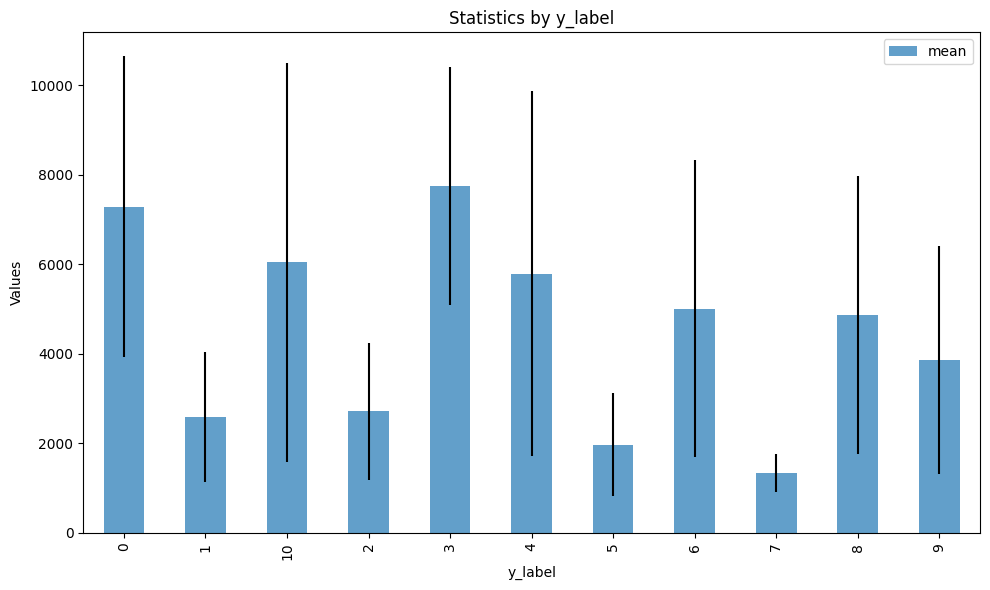

In [ ]:
import matplotlib.pyplot as plt

# y_label 별로 계산한 통계량을 가진 DataFrame에서 'mean'과 'std'를 구분하여 가져오기
mean_values = stats_by_y_label['clicks_so_far']['mean']
std_values = stats_by_y_label['clicks_so_far']['std']

# y_label에 따른 평균값(mean)을 막대로 표시하고 표준편차(std)를 오차 막대로 표시
plt.figure(figsize=(10, 6))
mean_values.plot(kind='bar', yerr=std_values, alpha=0.7, legend=True)

plt.title('Statistics by User ID)
plt.xlabel('User ID')
plt.ylabel('Clicks so far')

plt.tight_layout()
plt.show()


####Visualizing features

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# 데이터 스케일링
#scaler = StandardScaler()
#Scaled_X = scaler.fit_transform(X)


In [ ]:
X = df1.drop(['y_label'], axis=1)  # Assuming 'session_id' is not a feature
# One-hot encode categorical columns
y = df1['y_label'].astype(int)

In [ ]:
X.fillna(0, inplace=True)

In [ ]:
from xgboost import XGBClassifier  # XGBoostClassifier import

# 데이터를 훈련 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoostClassifier 모델 생성 및 훈련
xgb_model = XGBClassifier(random_state=42)  # XGBoostClassifier로 변경
xgb_model.fit(X_train, y_train)

# 테스트 세트로 예측
y_pred = xgb_model.predict(X_test)

# 모델 성능 평가
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# 결과 출력
print(f"Accuracy: {accuracy}")
print("\nClassification Report:")
print(report)


Accuracy: 0.9675290494068309

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     35263
           1       0.97      0.99      0.98    144400
           2       0.97      0.99      0.98    195666
           3       0.98      1.00      0.99    148184
           4       0.97      0.98      0.98    136077
           5       0.97      0.94      0.96     42096
           6       0.96      0.93      0.94     85627
           7       0.93      0.90      0.91     13315
           8       0.95      0.89      0.92     47538
           9       0.92      0.89      0.91     39730
          10       0.97      0.87      0.92     31572

    accuracy                           0.97    919468
   macro avg       0.96      0.94      0.95    919468
weighted avg       0.97      0.97      0.97    919468



In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

# Create a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Display classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.9966881469968037
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    123090
           1       1.00      1.00      1.00    508135
           2       1.00      1.00      1.00    685005
           3       1.00      1.00      1.00    518508
           4       1.00      1.00      1.00    476705
           5       0.99      0.99      0.99    146148
           6       0.99      1.00      1.00    299839
           7       0.99      0.98      0.99     46327
           8       1.00      0.99      0.99    166136
           9       0.99      0.99      0.99    138646
          10       1.00      0.99      0.99    109599

    accuracy                           1.00   3218138
   macro avg       1.00      0.99      0.99   3218138
weighted avg       1.00      1.00      1.00   3218138



In [ ]:
y_test

In [ ]:
feature_importance = pd.Series(rf_model.feature_importances_, index=X_test.columns)
feature_importance.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
import seaborn as sns

# 실제 값과 예측 값을 데이터프레임으로 변환
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 실제 값과 예측 값 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x=result_df.index, y='Actual', data=result_df, label='Actual', alpha=0.7)
sns.scatterplot(x=result_df.index, y='Predicted', data=result_df, label='Predicted', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [ ]:
import os
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# PCA를 사용하여 데이터 차원 축소 (2차원으로 설정)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# K-Means 클러스터링
kmeans = KMeans(n_clusters=11, random_state=42, n_init=10)
df1['Cluster'] = kmeans.fit_predict(X_pca)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue='Cluster', data=df1, palette='viridis', s=100)
centers = kmeans.cluster_centers_

for i in range(len(centers)):
    plt.scatter(centers[i, 0], centers[i, 1], marker='X', s=200, color='red', label=f'Centroid {i}')

plt.title('K-Means Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [ ]:
import os
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
# PCA를 사용하여 데이터 차원 축소 (2차원으로 설정)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# K-Means 클러스터링
kmeans = KMeans(n_clusters=11, random_state=42, n_init=10)
df1['Cluster'] = kmeans.fit_predict(X_pca)

# 시각화
plt.figure(figsize=(10, 6))

# 산점도 그리기
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue='Cluster', data=df1, palette='viridis', s=100)

# 중심점 표시
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker='X', s=200, color='red', label='Centroids')

plt.title('K-Means Clustering with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [ ]:
df1['Cluster']

In [ ]:
import pickle
# 변수를 불러오기
with open('/content/drive/My Drive/your_file.pkl', 'rb') as f:
    result = pickle.load(f)

In [ ]:
import pandas as pd

# 예측값과 실제값을 비교하여 새로운 칼럼 추가
mouse = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
mouse['Success'] = mouse.apply(lambda row: 1 if row['y_test'] == row['y_pred'] else 0, axis=1)

# 결과 확인
print(mouse)


In [ ]:
zero_success_rows = mouse[mouse['Success'] == 0]
print(zero_success_rows)

In [ ]:
mouse = mouse.groupby('y_test')['Success'].mean().reset_index()

In [ ]:
mouse.loc[mouse['Success'] < 1, 'Success'] = 0

In [ ]:
import pandas as pd
from scipy.stats import chi2

# 예측 결과
y_pred = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y_pred2 = [1, 1, 1, 1, 1, 1 ,1, 1, 1, 1, 1]

# McNemar 검증을 위한 변수 초기화
a, b, c, d = 0, 0, 0, 0

# McNemar 검증 수행
for pred1, pred2 in zip(y_pred, y_pred2):
    if pred1 == pred2:
        if pred1 == 0:
            a += 1
        else:
            d += 1
    else:
        if pred1 == 0:
            b += 1
        else:
            c += 1

# McNemar 검증 통계량 계산
X2 = ((abs(b - c) - 1) ** 2) / (b + c)
df = 1
p_value = chi2.sf(X2, df)

# 결과를 데이터프레임으로 정리
results = {
    '': ['모델 1 성공', '모델 1 실패'],
    '모델 2 성공': [d, b],
    '모델 2 실패': [c, a]
}

df_results = pd.DataFrame(results)

# McNemar 검증 통계량 및 p-value 추가
df_results['McNemar 검증 통계량'] = [X2, '']
df_results['p-value'] = [p_value, '']

# 결과 출력
print(df_results)


In [ ]:
from scipy.stats import shapiro

# 예시 데이터 (data라는 변수에 데이터를 할당)
# data = [your_data_here]

# Shapiro-Wilk 검정을 사용하여 정규성 검정
stat, p = shapiro(Scaled_X)

# 결과 출력
alpha = 0.05  # 유의수준
print(f'Statistics={stat}, p-value={p}')
if p > alpha:
    print('데이터는 정규분포를 따릅니다 (귀무가설 기각불가)')
else:
    print('데이터는 정규분포를 따르지 않습니다 (귀무가설 기각)')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 모델을 사용하여 테스트 데이터 예측
y_pred = model.predict(X_test)

# 모델 예측값을 클래스로 변환 (가장 높은 확률을 갖는 클래스 선택)
predicted_classes = np.argmax(y_pred, axis=1)

# 혼동 행렬 생성
conf_matrix = confusion_matrix(y_test, predicted_classes)

# 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()


In [ ]:
y_test

In [ ]:
import seaborn as sns

# 실제 값과 예측 값을 데이터프레임으로 변환
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 실제 값과 예측 값 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x=result_df.index, y='Actual', data=result_df, label='Actual', alpha=0.7)
sns.scatterplot(x=result_df.index, y='Predicted', data=result_df, label='Predicted', alpha=0.7)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [ ]:


# 예측 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(predictions, label='Predicted')
plt.title('True vs Predicted')
plt.legend()
plt.show()


In [ ]:
# 중복된 값의 개수 계산
duplicated_counts = df1.groupby(['client timestamp', 'click_frequency']).size().reset_index(name='count')

plt.scatter(duplicated_counts['client timestamp'], duplicated_counts['click_frequency'], s=duplicated_counts['count']*10, alpha=0.5)
plt.title('Variation of Click Frequency with Client Timestamp')
plt.ylabel('Click Frequency')
plt.xlabel('Client Timestamp')

# x축 범위를 0부터 100까지로 설정
plt.ylim(0.0, 3.0)
plt.show()


In [ ]:
df1['click_frequency'].head(30)

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(df1['client timestamp'], df1['click_frequency'])
plt.title('Variation of Click Frequency with Client Timestamp')
plt.ylabel('Click Frequency')
plt.xlabel('Client Timestamp')

# x축 범위를 0부터 100까지로 설정
plt.xlim(0.0, 2000.0)
plt.ylim(0.0, 3.0)
plt.show()


In [ ]:
plt.scatter(df1['client timestamp'], df1['click_frequency'])
plt.title('Variation of Click Frequency with Client Timestamp')
plt.ylabel('Click Frequency')
plt.xlabel('Client Timestamp')

plt.show()

In [ ]:
plt.scatter(df1['client timestamp'], df1['mouse_speed'])
plt.title('Variation of Mouse Speed with Client Timestamp')
plt.xlabel('Client Timestamp')
plt.ylabel('Mouse Speed')
plt.show()

In [ ]:
plt.scatter(df1['client timestamp'], df1['curvature'])
plt.title('Variation of Curvature with Client Timestamp')
plt.xlabel('Client Timestamp')
plt.ylabel('Curvature')
plt.show()